In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
data_path = "./data/"

In [2]:
gear_data = pd.read_csv(data_path + 'HYDRAULIC_GROUP_processed.csv')
gear_data.head(5)

,Turbine_ID,Timestamp,Hyd_Oil_Temp_Avg,Min_Windspeed1,Max_Windspeed1,Avg_Windspeed1,Var_Windspeed1,Min_Windspeed2,Max_Windspeed2,Avg_Windspeed2,...,Anemometer2_CorrOffset,DistanceAirPress,AirRessureSensorZeroOffset,Anemometer1_Avg_Freq,Anemometer2_Avg_Freq,Pressure_Avg_Freq,Label,Next_Default_Date,Lead_Time,Default_in_60
0,T01,2016-01-01 00:00:00+00:00,30.0,3.7,6.0,5.1,0.21,3.8,6.0,5.1,...,0.0,0.0,600.0,98.0,99.0,418.0,0.0,2262-04-11 00:00:00+00:00,89950,False
1,T01,2016-01-01 00:10:00+00:00,30.0,4.1,6.0,5.1,0.09,4.1,6.0,5.2,...,0.0,0.0,600.0,99.0,101.0,418.0,0.0,2262-04-11 00:00:00+00:00,89949,False
2,T01,2016-01-01 00:20:00+00:00,30.0,4.5,6.7,5.7,0.26,4.4,6.8,5.8,...,0.0,0.0,600.0,111.0,113.0,418.0,0.0,2262-04-11 00:00:00+00:00,89949,False
3,T01,2016-01-01 00:30:00+00:00,30.0,5.1,7.0,6.3,0.11,5.1,7.1,6.4,...,0.0,0.0,600.0,122.0,125.0,418.0,0.0,2262-04-11 00:00:00+00:00,89949,False
4,T01,2016-01-01 00:40:00+00:00,30.0,4.7,7.3,6.2,0.27,4.9,7.4,6.3,...,0.0,0.0,600.0,121.0,123.0,417.0,0.0,2262-04-11 00:00:00+00:00,89949,False


In [3]:
# Feature Engineering
dummies = pd.get_dummies(gear_data['Turbine_ID'], prefix= 'is_', drop_first= True)
data = pd.concat([gear_data, dummies], axis = 1)

# Normalize features, filter the dummy variables
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(data.iloc[:, 2:-8].values)
scaled_features = pd.DataFrame(scaled_features, 
                        index = data.iloc[:, 2:-8].index, 
                        columns= data.columns[2:-8])
fit_data = pd.concat([data.iloc[:, :2], scaled_features, dummies, data.iloc[:, -8: -4]], axis = 1)

In [4]:
# Undersample method
def undersample_majority(x, y):
    class_counts = np.bincount(y)
    minority_class = np.argmin(class_counts)
    majority_class = np.argmax(class_counts)
    majority_to_keep = class_counts[minority_class]
    majority_idx = np.where(y == majority_class)[0]
    majority_idx_new = np.random.choice(majority_idx, majority_to_keep, replace=False)
    minority_idx = np.where(y == minority_class)[0]
    idx_to_keep = np.concatenate((majority_idx_new, minority_idx))
    return x[idx_to_keep], y[idx_to_keep]

# Oversample method
def oversample_minority(x, y):
    class_counts = np.bincount(y)
    minority_class = np.argmin(class_counts)
    majority_class = np.argmax(class_counts)
    
    n_samples = class_counts[majority_class]
    minority_idx = np.where(y == minority_class)[0]
    majority_idx = np.where(y == majority_class)[0]

    x_minority_oversampled, y_minority_oversampled = resample(
        x[minority_idx],
        y[minority_idx],
        replace=True,
        n_samples=n_samples - len(minority_idx),
        random_state=123
    )

    x_oversampled = np.vstack((x[majority_idx], x_minority_oversampled))
    y_oversampled = np.hstack((y[majority_idx], y_minority_oversampled))
    return x_oversampled, y_oversampled


In [5]:
## Create time-series dataset
def create_dataset(X, y, time_steps=1):
    
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [6]:
test_size = 0.25
val_size = 0.15
steps = 6*24

fit_data['Timestamp'] = pd.to_datetime(fit_data['Timestamp'])
split_date = fit_data['Timestamp'].quantile(0.25)

test_df = fit_data[fit_data['Timestamp'] <= split_date]
train_df = fit_data[fit_data['Timestamp'] > split_date]

features = fit_data.iloc[:, 2:-5].columns
X_test, y_test = create_dataset(test_df[features].values, test_df['Default_in_60'].values, steps)
X_train, y_train = create_dataset(train_df[features].values, train_df['Default_in_60'].values, steps)


In [7]:
X_train, y_train = undersample_majority(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=66)
X_train.shape, y_train.shape

((59124, 144, 44), (59124,))

In [8]:
# Build LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences= False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall()])


history = model.fit(
    X_train, y_train.astype(float),
    validation_data = (X_val, y_val.astype(float)),
    epochs= 50,
    batch_size= 32,
    callbacks=[EarlyStopping(monitor='val_loss', patience= 5)],
    shuffle=False
)



Epoch 1/50


1848/1848 [==============================] - 51s 27ms/step - loss: 0.5650 - accuracy: 0.6691 - recall: 0.8362 - val_loss: 0.5143 - val_accuracy: 0.7102 - val_recall: 0.6637
Epoch 2/50
1848/1848 [==============================] - 64s 35ms/step - loss: 0.5445 - accuracy: 0.6978 - recall: 0.8179 - val_loss: 0.4820 - val_accuracy: 0.7535 - val_recall: 0.8228
Epoch 3/50
1848/1848 [==============================] - 53s 29ms/step - loss: 0.5021 - accuracy: 0.7306 - recall: 0.8727 - val_loss: 0.4655 - val_accuracy: 0.7717 - val_recall: 0.8192
Epoch 4/50
1848/1848 [==============================] - 63s 34ms/step - loss: 0.5785 - accuracy: 0.6570 - recall: 0.8399 - val_loss: 0.5526 - val_accuracy: 0.6833 - val_recall: 0.8503
Epoch 5/50
1848/1848 [==============================] - 57s 31ms/step - loss: 0.5359 - accuracy: 0.7024 - recall: 0.8775 - val_loss: 0.4888 - val_accuracy: 0.7487 - val_recall: 0.8147
Epoch 6/50
1848/1848 [==============================] - 64s 35ms/step - loss

In [9]:
# Evaluation function
def evaluate_model(y_pred, y_true):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy}")
    precision = precision_score(y_true, y_pred)
    print(f"Precision: {precision}")
    recall = recall_score(y_true, y_pred)
    print(f"Recall: {recall}")
    f1 = f1_score(y_true, y_pred)
    print(f"F1 Score: {f1}")

In [10]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = y_test.astype(int)
evaluate_model(y_pred, y_true)

3388/3388 [==============================] - 18s 5ms/step
Accuracy: 0.8097078958537081
Precision: 0.00126251998989984
Recall: 0.0017095965352176886
F1 Score: 0.0014524328249818444


In [11]:
y_pred.shape, y_true.shape

((108386,), (108386,))

In [12]:
predict_time = test_df[['Turbine_ID', 'Timestamp']].iloc[steps:].reset_index(drop=True)
pred_df = pd.DataFrame({
    'Turbine_ID': predict_time['Turbine_ID'],
    'Timestamp': predict_time['Timestamp'],
    'Prediction': y_pred.flatten()
})

In [13]:
test_df_pred = test_df.iloc[:-steps].copy()
test_df_pred = test_df_pred.merge(pred_df, on=['Turbine_ID', 'Timestamp'], how='left')
test_df_pred

,Turbine_ID,Timestamp,Hyd_Oil_Temp_Avg,Min_Windspeed1,Max_Windspeed1,Avg_Windspeed1,Var_Windspeed1,Min_Windspeed2,Max_Windspeed2,Avg_Windspeed2,...,Pressure_Avg_Freq,is__T06,is__T07,is__T09,is__T11,Label,Next_Default_Date,Lead_Time,Default_in_60,Prediction
0,T01,2016-01-01 00:00:00+00:00,0.285714,0.207865,0.194805,0.220779,0.005983,0.219653,0.206897,0.222707,...,0.722222,0,0,0,0,0.0,2262-04-11 00:00:00+00:00,89950,False,NaN
1,T01,2016-01-01 00:10:00+00:00,0.285714,0.230337,0.194805,0.220779,0.002564,0.236994,0.206897,0.227074,...,0.722222,0,0,0,0,0.0,2262-04-11 00:00:00+00:00,89949,False,NaN
2,T01,2016-01-01 00:20:00+00:00,0.285714,0.252809,0.217532,0.246753,0.007407,0.254335,0.234483,0.253275,...,0.722222,0,0,0,0,0.0,2262-04-11 00:00:00+00:00,89949,False,NaN
3,T01,2016-01-01 00:30:00+00:00,0.285714,0.286517,0.227273,0.272727,0.003134,0.294798,0.244828,0.279476,...,0.722222,0,0,0,0,0.0,2262-04-11 00:00:00+00:00,89949,False,NaN
4,T01,2016-01-01 00:40:00+00:00,0.285714,0.264045,0.237013,0.268398,0.007692,0.283237,0.255172,0.275109,...,0.694444,0,0,0,0,0.0,2262-04-11 00:00:00+00:00,89949,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108381,T11,2016-05-29 23:10:00+00:00,0.314286,0.264045,0.188312,0.229437,0.001425,0.260116,0.200000,0.231441,...,0.583333,0,0,0,1,0.0,2016-10-17 17:40:00+00:00,140,False,0.0
108382,T11,2016-05-29 23:20:00+00:00,0.314286,0.247191,0.175325,0.212121,0.001425,0.248555,0.186207,0.209607,...,0.583333,0,0,0,1,0.0,2016-10-17 17:40:00+00:00,140,False,0.0
108383,T11,2016-05-29 23:30:00+00:00,0.314286,0.219101,0.162338,0.199134,0.001425,0.219653,0.172414,0.200873,...,0.583333,0,0,0,1,0.0,2016-10-17 17:40:00+00:00,140,False,0.0
108384,T11,2016-05-29 23:40:00+00:00,0.314286,0.207865,0.188312,0.212121,0.005128,0.196532,0.200000,0.209607,...,0.583333,0,0,0,1,0.0,2016-10-17 17:40:00+00:00,140,False,0.0


In [14]:
test_df_pred['Timestamp'] = pd.to_datetime(test_df_pred['Timestamp'])
test_df_pred['Next_Default_Date'] = pd.to_datetime(test_df_pred['Next_Default_Date'])

FP = 0
FN = 0
signals = {}

savings = 0
R, M, I = 100000, 20000, 5000

for index, row in test_df_pred.iterrows():
    turbine_id = row['Turbine_ID']
    next_default_date = row['Next_Default_Date']
    key = (turbine_id, str(next_default_date))

    if key not in signals:
        signals[key] = {'early_warn': None, 'had_failure': False, 'time_diff': 0}

    if row['Label'] == 1:
        signals[key]['had_failure'] = True
    
    if pd.notna(row['Prediction']) and row['Prediction'] == 1.0:
        warn_time = row['Timestamp']
        time_diff = (next_default_date - warn_time).total_seconds() / 60

        if time_diff > 60 * 24 * 60:
            FP += 1
        else:
            if 0 < time_diff <= 60 * 24 * 60:           
                if signals[key]['early_warn'] is None or warn_time < signals[key]['early_warn']:
                    signals[key]['early_warn'] = warn_time
                    signals[key]['time_diff'] = time_diff


for (turbine_id, default_date), info in signals.items():
    default_time = pd.to_datetime(default_date)
    if info['had_failure']:
        if info['early_warn'] is None:
            FN += 1
        else:
            warn_time = info['early_warn']
            time_diff = info['time_diff']
            savings += (time_diff / (60 * 24)) * (R - M)

savings -= FP * I
savings -= FN * M

print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")
print(f"Total savings: {savings}")

False Positives: 11808
False Negatives: 0
Total savings: -55019444.44444445


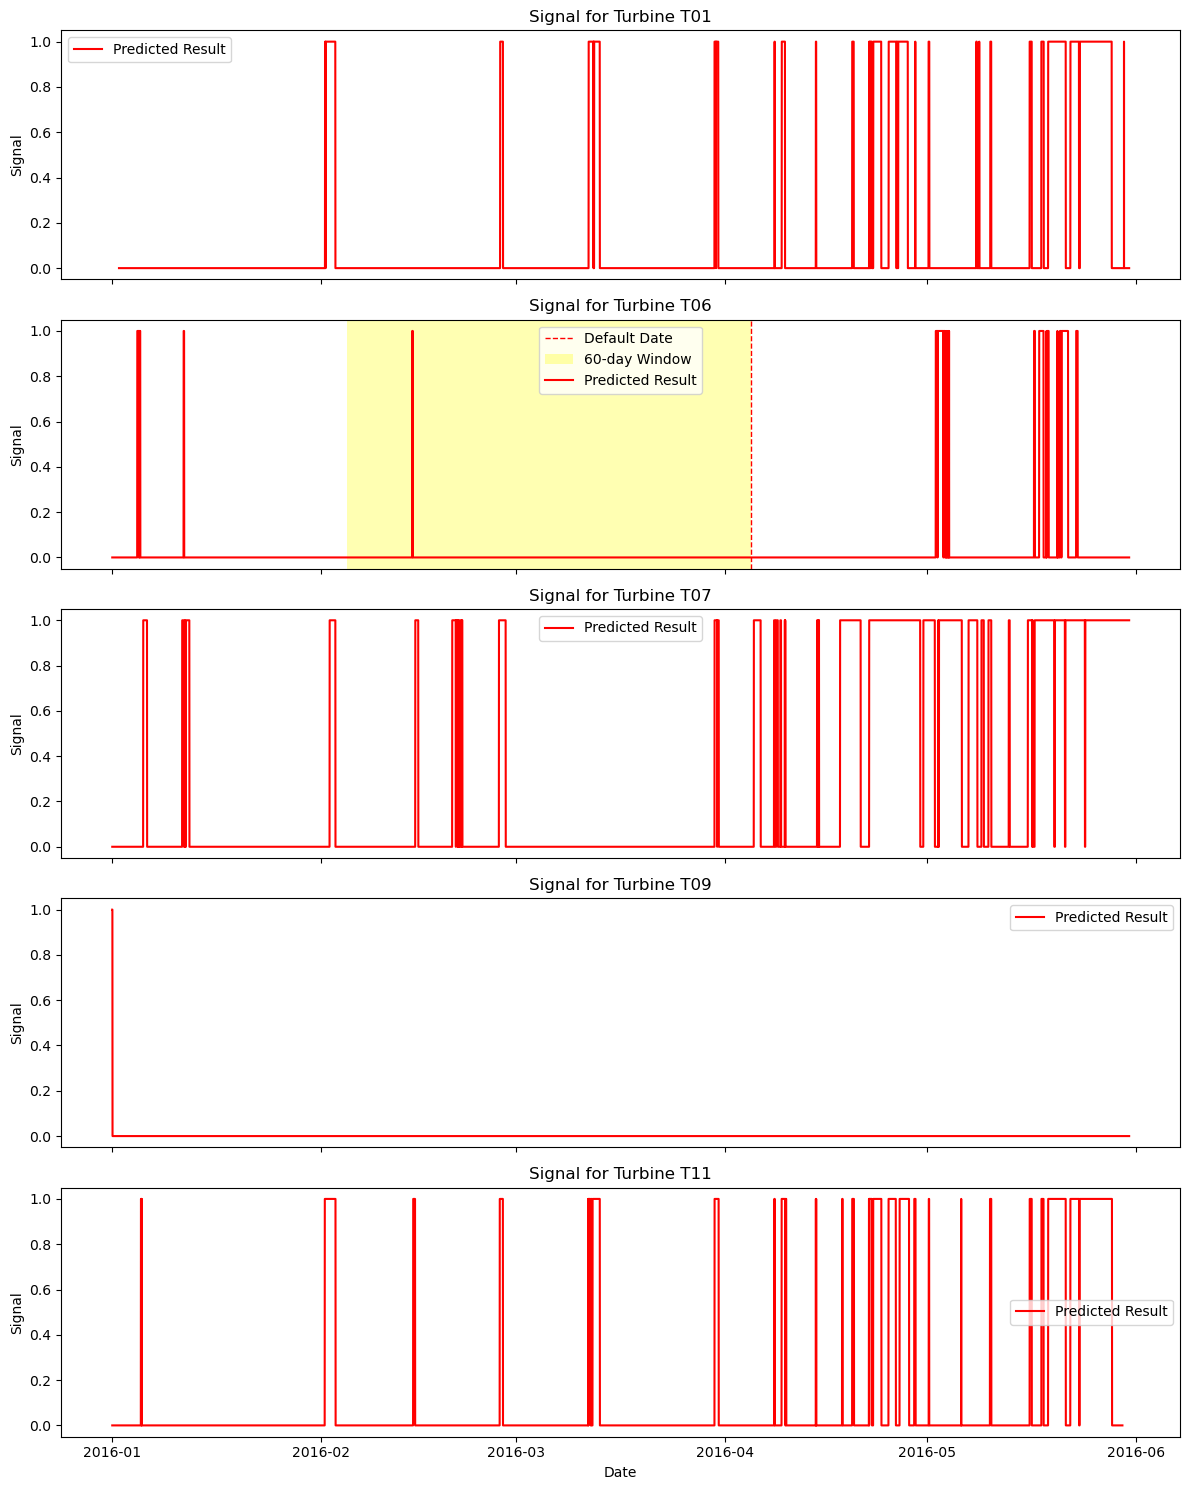

In [15]:
max_test_default_date = test_df_pred['Timestamp'].max()
turbine_ids = test_df_pred['Turbine_ID'].unique()

nrows = len(turbine_ids)
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(12, 3 * nrows), sharex=True)
axes = axes.flatten() if nrows > 1 else [axes]

for i, turbine_id in enumerate(turbine_ids):
    turbine_data = test_df_pred[test_df_pred['Turbine_ID'] == turbine_id]
    unique_dates = turbine_data['Next_Default_Date'].drop_duplicates()

    for default_date in unique_dates:
        if default_date <= max_test_default_date:
            axes[i].axvline(x=default_date, color='r', linestyle='--', linewidth=1, label='Default Date')
            start_pre_window = default_date - pd.Timedelta(days=60)
            axes[i].axvspan(start_pre_window, default_date, color='yellow', alpha=0.3, label='60-day Window', linewidth=0)

    axes[i].plot(turbine_data['Timestamp'], turbine_data['Prediction'], color='red', label='Predicted Result')

    axes[i].set_title(f'Signal for Turbine {turbine_id}')
    axes[i].set_ylabel('Signal')
    axes[i].legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()

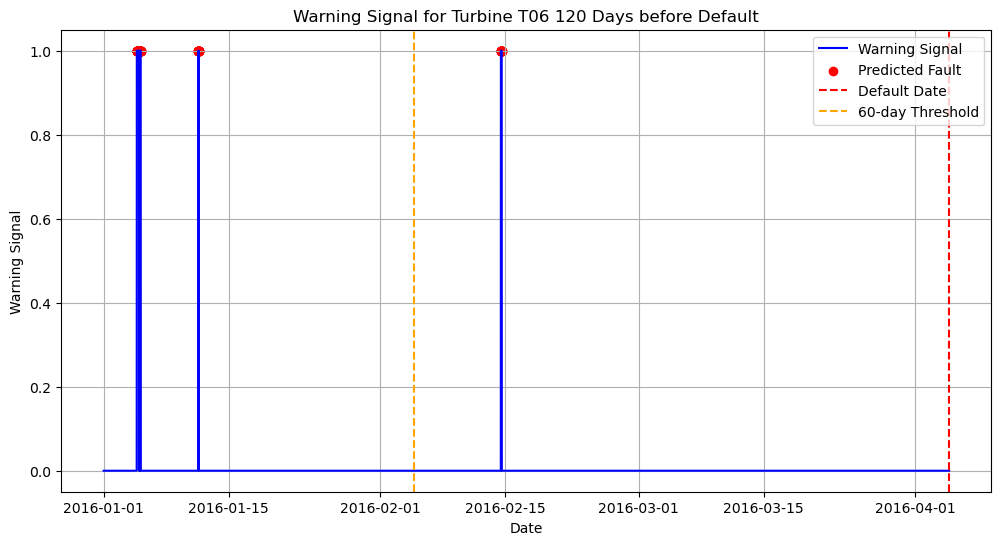

In [16]:
## Experiment and warning visualization
turbine_id = 'T06'
default_date = pd.to_datetime('2016-04-04 18:50:00+00:00')

start_warning_date = default_date - pd.Timedelta(days = 120)
mask = (test_df_pred['Turbine_ID'] == turbine_id) & \
       (test_df_pred['Timestamp'] >= start_warning_date) & \
       (test_df_pred['Timestamp'] <= default_date)

warning_data = test_df_pred[mask]

plt.figure(figsize=(12, 6))
plt.plot(warning_data['Timestamp'], warning_data['Prediction'], label='Warning Signal', color='blue')

predicted_faults = warning_data[warning_data['Prediction'] == 1]
plt.scatter(predicted_faults['Timestamp'], predicted_faults['Prediction'], color='red', label='Predicted Fault')

plt.axvline(x=default_date, color='r', linestyle='--', label='Default Date')
plt.axvline(x=default_date - pd.Timedelta(days=60), color='orange', linestyle='--', label='60-day Threshold')

plt.title(f'Warning Signal for Turbine {turbine_id} 120 Days before Default')
plt.xlabel('Date')
plt.ylabel('Warning Signal')
plt.legend()
plt.grid(True)
plt.show()